# FOOD AT Dallas - An exploratory analysis on the Dallas, TX food scene

This project is a statistical analysis on restaurants in Dallas, Texas, using YELP API data. I used the YELP API to scrape summary data for 25 miles within the google search, "Dallas, TX") and collected data. Any repeat restaurants were removed.

### For index to work, click [here](https://nbviewer.org/github/yashwanth033/Food_in_Dallas/blob/main/food_at_dallas.ipynb)


# Index (click to redirect to section)

## [Data pre-processing](#data-preprocessing)
- [Clean the data](#clean-the-data)

## [Summary Statistics](#summary-statistics)
- [Overall assessment of review_count, rating, price](#summary-statistics)
- [Categorical assessment of review_count, rating, price, total number](#categorical)
- [Geographic Data](#geography)





# Gathering data:

Please see gather_data.ipynb for methods. This can be found it [this github repository](https://github.com/yashwanth033/Food_in_Dallas).

# Data Pre-processing
Here, we read in the data and convert it to dataframe

In [133]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings
from yelphelpers import *

warnings.filterwarnings('ignore')

with open('restaurants.json') as f:
    data = json.load(f)

In [134]:
df = pd.DataFrame.from_dict(data, orient='columns')

In [135]:
df.head()

,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,transactions,location,phone,display_phone,distance,price
0,2jxPJngbOs5YU7keUJ1LyA,hawaiian-bros-island-grill-dallas,Hawaiian Bros Island Grill,https://s3-media2.fl.yelpcdn.com/bphoto/IEiM4a...,False,https://www.yelp.com/biz/hawaiian-bros-island-...,15,"[{'alias': 'hawaiian', 'title': 'Hawaiian'}, {...",4.5,"{'latitude': 32.8586594, 'longitude': -96.76862}","[delivery, pickup]","{'address1': '6011 Greenville Ave', 'address2'...",+12142068646,(214) 206-8646,3694.210297,NaN
1,9uaSZzLB7CEHGc4mokQxig,the-porch-dallas,The Porch,https://s3-media2.fl.yelpcdn.com/bphoto/ZwkvZQ...,False,https://www.yelp.com/biz/the-porch-dallas?adju...,1450,"[{'alias': 'southern', 'title': 'Southern'}, {...",4.0,"{'latitude': 32.82064248039, 'longitude': -96....","[delivery, pickup]","{'address1': '2912 N Henderson Ave', 'address2...",+12148282916,(214) 828-2916,2522.535657,$$
2,bml-gjgOTeSYJI-Gq6bMRA,monarch-dallas,Monarch,https://s3-media2.fl.yelpcdn.com/bphoto/eM-zwN...,False,https://www.yelp.com/biz/monarch-dallas?adjust...,260,"[{'alias': 'italian', 'title': 'Italian'}, {'a...",4.0,"{'latitude': 32.781565163451, 'longitude': -96...",[],"{'address1': '1401 Elm St', 'address2': 'Fl 49...",+12149452222,(214) 945-2222,6391.306447,$$$$
3,CREIs-59rrp8OhG9VppCqA,ellens-dallas-4,Ellen's,https://s3-media3.fl.yelpcdn.com/bphoto/3xh0YL...,False,https://www.yelp.com/biz/ellens-dallas-4?adjus...,2843,"[{'alias': 'southern', 'title': 'Southern'}, {...",4.0,"{'latitude': 32.7818955295251, 'longitude': -9...","[delivery, restaurant_reservation, pickup]","{'address1': '1790 N Record St', 'address2': N...",+14692063339,(469) 206-3339,6388.866168,$$
4,qtOSR7WS36sbAQi0ySSuEg,r-d-kitchen-dallas,R+D Kitchen,https://s3-media4.fl.yelpcdn.com/bphoto/0uzVTw...,False,https://www.yelp.com/biz/r-d-kitchen-dallas?ad...,547,"[{'alias': 'newamerican', 'title': 'American (...",4.0,"{'latitude': 32.863065, 'longitude': -96.802789}",[delivery],"{'address1': '8300 Preston Ctr Plz', 'address2...",+12148907900,(214) 890-7900,2679.338235,$$


In [136]:
print("Missing data:")
df.isnull().sum()

Missing data:


id                0
alias             0
name              0
image_url         0
is_closed         0
url               0
review_count      0
categories        0
rating            0
coordinates       0
transactions      0
location          0
phone             0
display_phone     0
distance          0
price            46
dtype: int64

<a id="clean-the-data"></a>
## Cleaning the data

Here, we need to:

* Remove unnecessary data

* One-hot encode categories list

* Convert string data into numberic data (rating, price)

* Add neighbourhood name based on zip code (see [Geographic Data](#geography))

In [137]:
#  Remove unnecessary data
df = df.drop(columns=['image_url','is_closed','transactions','phone','display_phone'])

# Replace number signs ($) with numerical values
df.replace(['$','$$','$$$','$$$$'],[1.0,2.0,3.0,4.0], inplace=True)

In [138]:
# Expand the list, "categories", into separate columns (one-hot encoding)
df_categories = df[['id', 'categories']]
df.drop(columns=['categories'],inplace=True)
df.rename(columns={'alias':'r_alias'},inplace=True)

In [139]:
df_expanded = df.copy().merge(expand_list(df_categories.copy(), 'categories'))
df_categories = expand_list(df_categories,'categories')
df_categories = pd.concat([df_categories.drop(['categories'], axis=1), df_categories['categories'].apply(pd.Series)], axis=1)
df_categories = df_categories.groupby(['id']).agg(lambda x: tuple(x)).applymap(list).reset_index()

df = df.merge(df_categories, on='id')
df = df.drop('alias', 1).join(df.alias.str.join('|').str.get_dummies())


# To find categorical data, we need to split restaurants with multiple categories into separate entries.
df_expanded = pd.concat([df_expanded.drop(['categories'], axis=1), df_expanded['categories'].apply(pd.Series)], axis=1)

# Clean up some variables to leave more space
df_categories = None

In [140]:
df.head()

,id,r_alias,name,url,review_count,rating,coordinates,location,distance,price,...,tapasmallplates,teppanyaki,tex-mex,thai,tradamerican,turkish,vegan,vegetarian,vietnamese,wine_bars
0,2jxPJngbOs5YU7keUJ1LyA,hawaiian-bros-island-grill-dallas,Hawaiian Bros Island Grill,https://www.yelp.com/biz/hawaiian-bros-island-...,15,4.5,"{'latitude': 32.8586594, 'longitude': -96.76862}","{'address1': '6011 Greenville Ave', 'address2'...",3694.210297,NaN,...,0,0,0,0,0,0,0,0,0,0
1,9uaSZzLB7CEHGc4mokQxig,the-porch-dallas,The Porch,https://www.yelp.com/biz/the-porch-dallas?adju...,1450,4.0,"{'latitude': 32.82064248039, 'longitude': -96....","{'address1': '2912 N Henderson Ave', 'address2...",2522.535657,2.0,...,0,0,0,0,0,0,0,0,0,0
2,bml-gjgOTeSYJI-Gq6bMRA,monarch-dallas,Monarch,https://www.yelp.com/biz/monarch-dallas?adjust...,260,4.0,"{'latitude': 32.781565163451, 'longitude': -96...","{'address1': '1401 Elm St', 'address2': 'Fl 49...",6391.306447,4.0,...,0,0,0,0,0,0,0,0,0,0
3,CREIs-59rrp8OhG9VppCqA,ellens-dallas-4,Ellen's,https://www.yelp.com/biz/ellens-dallas-4?adjus...,2843,4.0,"{'latitude': 32.7818955295251, 'longitude': -9...","{'address1': '1790 N Record St', 'address2': N...",6388.866168,2.0,...,0,0,0,0,1,0,0,0,0,0
4,qtOSR7WS36sbAQi0ySSuEg,r-d-kitchen-dallas,R+D Kitchen,https://www.yelp.com/biz/r-d-kitchen-dallas?ad...,547,4.0,"{'latitude': 32.863065, 'longitude': -96.802789}","{'address1': '8300 Preston Ctr Plz', 'address2...",2679.338235,2.0,...,0,0,0,0,0,0,0,0,0,0


In [141]:
df.describe()

,review_count,rating,distance,price,argentine,asianfusion,bakeries,bars,bbq,beer_and_wine,...,tapasmallplates,teppanyaki,tex-mex,thai,tradamerican,turkish,vegan,vegetarian,vietnamese,wine_bars
count,200.000000,200.000000,200.000000,154.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,...,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,418.740000,4.217500,4236.654892,2.142857,0.005000,0.030000,0.010000,0.105000,0.050000,0.005000,...,0.025000,0.005000,0.050000,0.025000,0.105000,0.005000,0.005000,0.015000,0.015000,0.055000
std,633.615479,0.396522,2049.974143,0.651078,0.070711,0.171015,0.099748,0.307323,0.218492,0.070711,...,0.156517,0.070711,0.218492,0.156517,0.307323,0.070711,0.070711,0.121857,0.121857,0.228552
min,1.000000,3.000000,582.640527,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,90.500000,4.000000,2677.901671,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,206.000000,4.000000,3950.924687,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,476.500000,4.500000,5519.190569,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,5424.000000,5.000000,11339.055781,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<a id="summary-statistics"></a>
# Summary Statistics

## Overall assessment of review_count, rating, price

Here, we take a look at the general statistics for restaurant data.

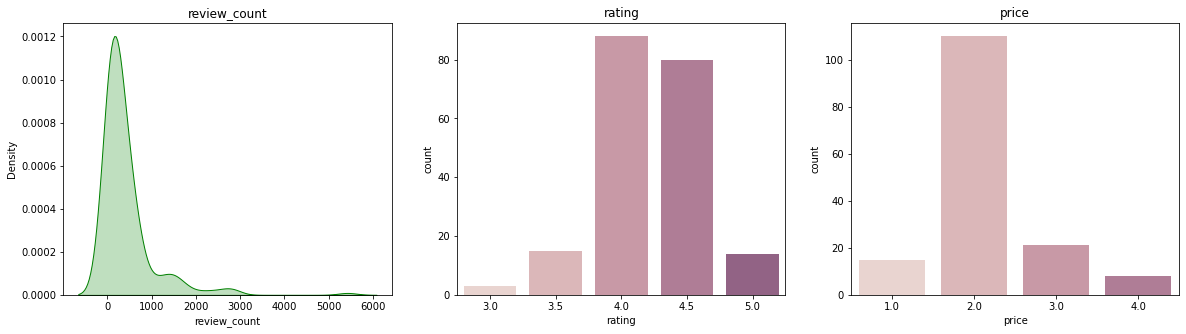

In [142]:
fig, axes = plt.subplots(1,3,figsize=(20,5))
sns.set_palette(sns.cubehelix_palette(8))
sns.distplot(df['review_count'], hist=False, color="g", ax=axes[0], kde_kws={"shade": True}).set_title('review_count')
sns.countplot(df['rating'],ax=axes[1]).set_title('rating')
sns.countplot(df['price'],ax=axes[2]).set_title('price')
plt.show()

Now, let's take a look at some boxplots to see how the data is distributed and the outliers.

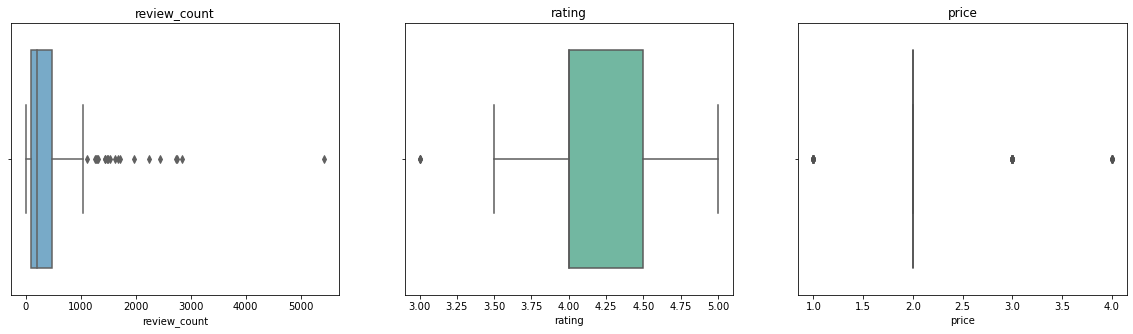

In [143]:
fig, axes = plt.subplots(1,3,figsize=(20,5))
sns.boxplot(df['review_count'],ax=axes[0],palette='Blues').set_title('review_count')
sns.boxplot(df['rating'],ax=axes[1], palette='BuGn_r').set_title('rating')
sns.boxplot(df['price'],ax=axes[2], palette='GnBu_d').set_title('price')
plt.show()

In the review_count boxplot, it seems like the data surpasses much past the whiskers of the maximum value, which classify them as outliers. This irregular distribution is represented as well in the right skewed distribution plot above. 

When looking at rating data, it seems that most data fall within 3.0 - 4.0, with a rating of 1.0 classified as outliers. This can be due to a few restaurants that seem to attract particularly only negative reviews. When talking about restaurant ratings, it would make sense that only a few restaurants have a 1.0 rating. Most restaurants, which have work put into them, would average to be even a little higher than the absolute minimum. A possible explanation for the restaurants with a 1.0 rating is that they are new and only have a couple of ratings on Yelp.


Similarly, only a few restaurants do have the 4.0 price label, which put them as outliers.

<a id="categorical"></a>
## Categorical assessment of review_count, rating, price, total number

In this next section, we find these same statistics by category. The Bayesian average of each property was used to graph it by category, in descending order.

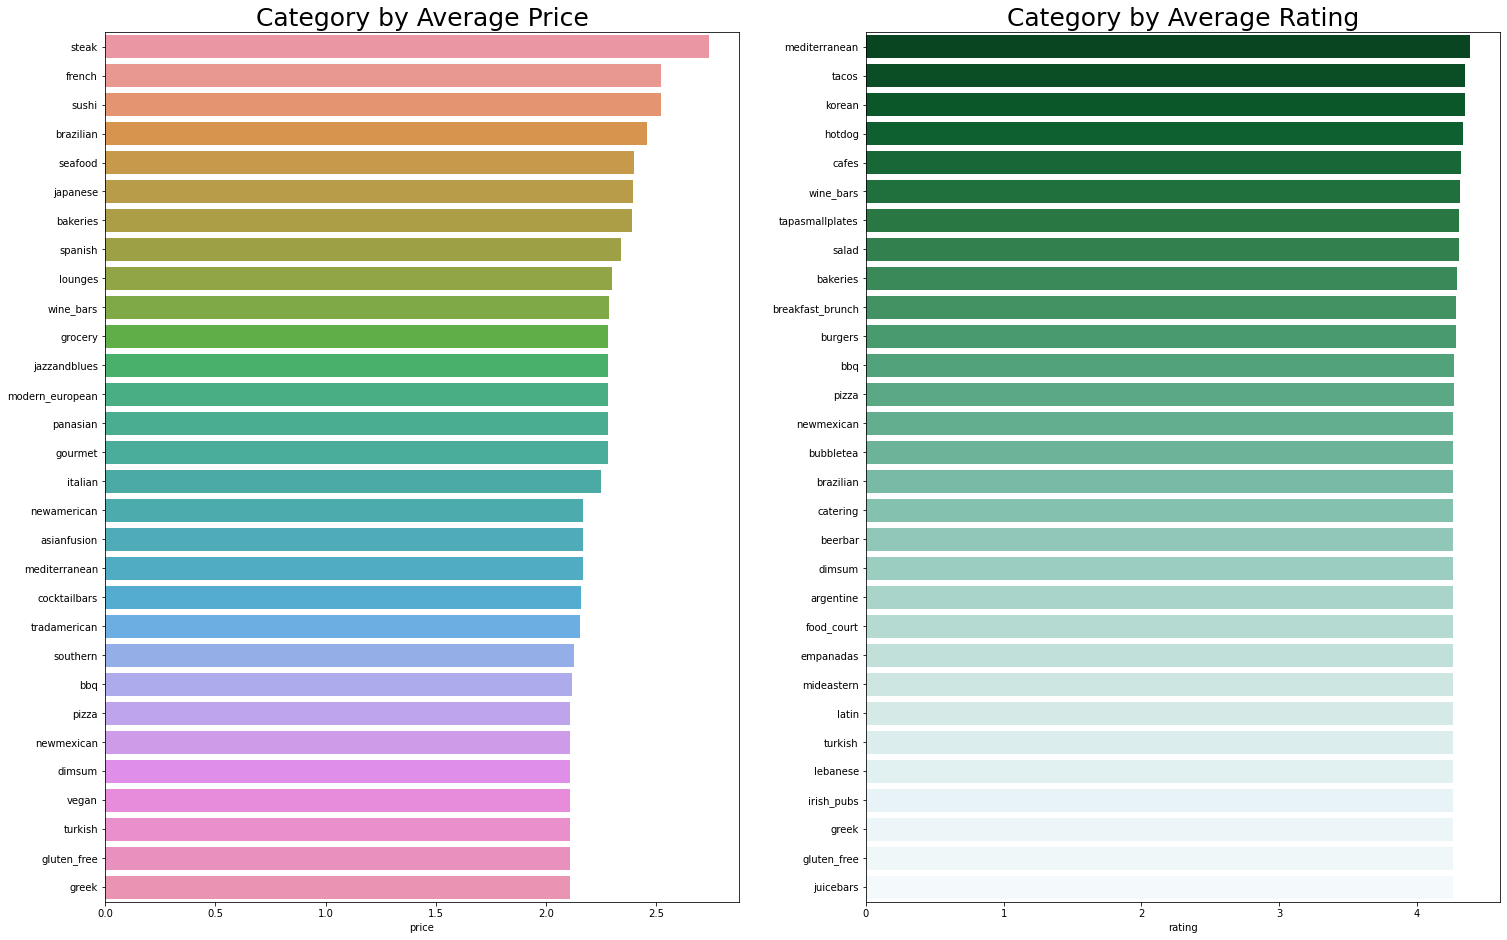

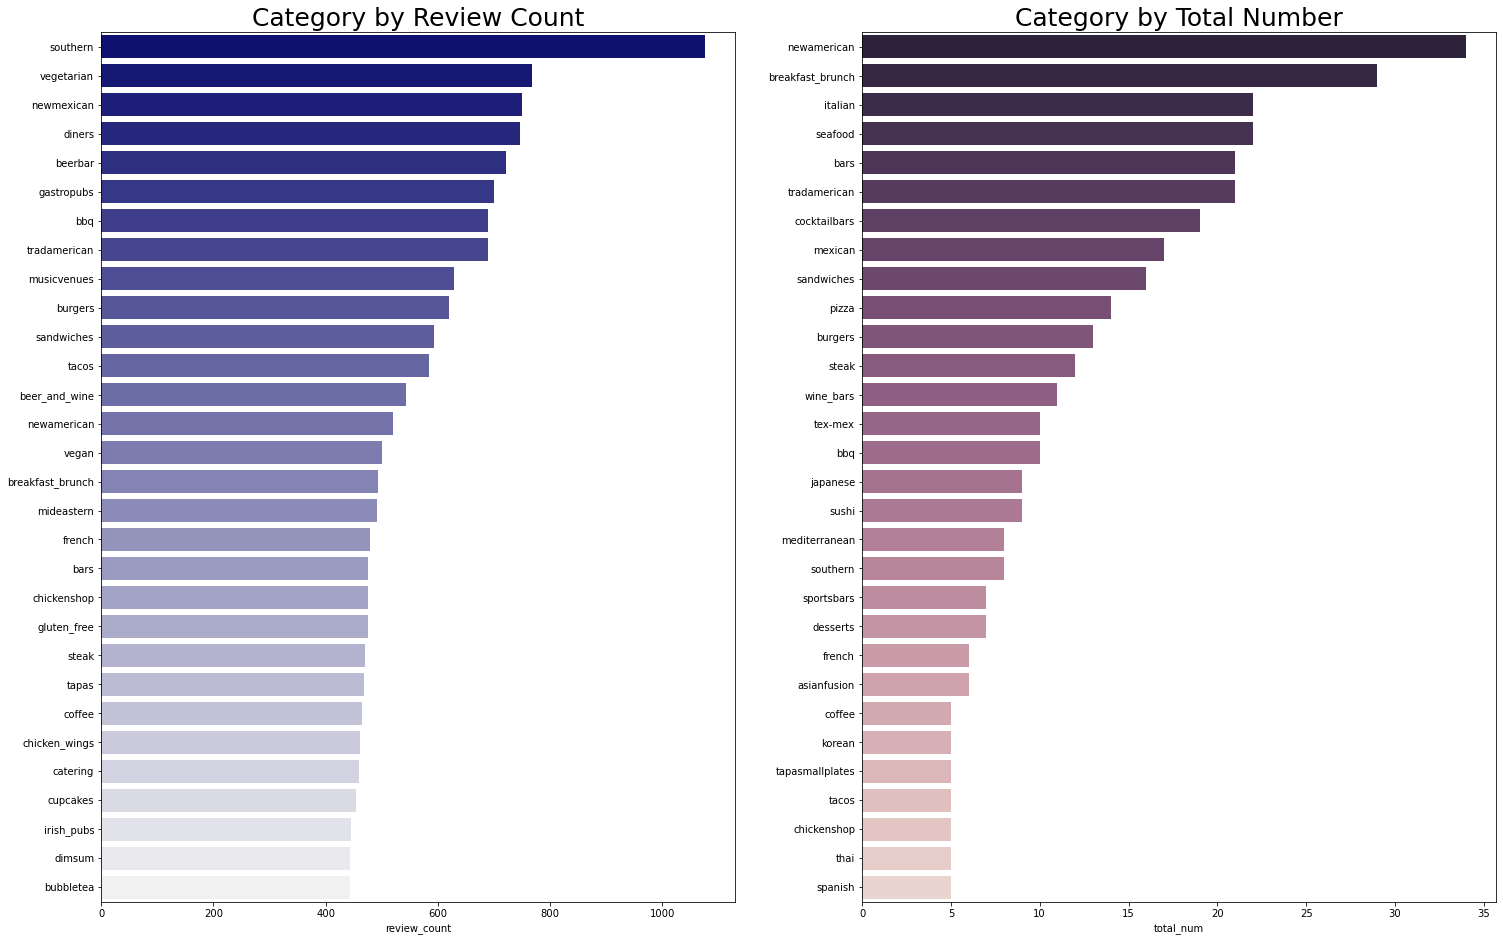

In [144]:
n = 30

### PRICE ###
pr = (bayes_avg(df_expanded.dropna(how='any'), 'alias', 'price').sort_values(ascending=False)
     .reset_index().sort_values('price', ascending=False))
pr = pr.iloc[:n]
### RATING
ra = (bayes_avg(df_expanded, 'alias', 'rating').sort_values(ascending=False)
     .reset_index().sort_values('rating', ascending=False))
ra = ra.iloc[:n]
### REVIEW_COUNT
re = (bayes_avg(df_expanded, 'alias', 'review_count').sort_values(ascending=False)
     .reset_index().sort_values('review_count', ascending=False))
re = re.iloc[:n]
### NUMBER OF RESTAURANTS
nu = (df.drop(['id', 'r_alias', 'name','url','review_count','rating','coordinates','price','location', \
         'distance', 'title'], axis=1).sum().sort_values(ascending=False))
nu = nu.reset_index().iloc[:n]
nu.rename(columns={'index': 'alias', 0:'total_num'}, inplace=True)




# first fig
fig, axes = plt.subplots(1,2,figsize=(25,16))
sns.set_palette(sns.cubehelix_palette(8))
sns.barplot(data=pr,x='price',y='alias',orient='h',ax=axes[0]).set_title('Category by Average Price', fontsize=25)
axes[0].set_ylabel('')

sns.barplot(data=ra,x='rating',y='alias',orient='h',ax=axes[1], palette="BuGn_r").set_title('Category by Average Rating', fontsize=25)
axes[1].set_ylabel('')

# second fig
fig, axes = plt.subplots(1,2,figsize=(25,16))
sns.set_palette('ch:8')

sns.barplot(data=re,x='review_count',y='alias',orient='h',ax=axes[0], palette=sns.light_palette("navy", n_colors=n, reverse=True)).set_title('Category by Review Count', fontsize=25)
axes[0].set_ylabel('')

sns.barplot(data=nu,x='total_num',y='alias',orient='h',ax=axes[1], palette=sns.cubehelix_palette(n, reverse=True)).set_title('Category by Total Number', fontsize=25)
axes[1].set_ylabel('')

plt.show()

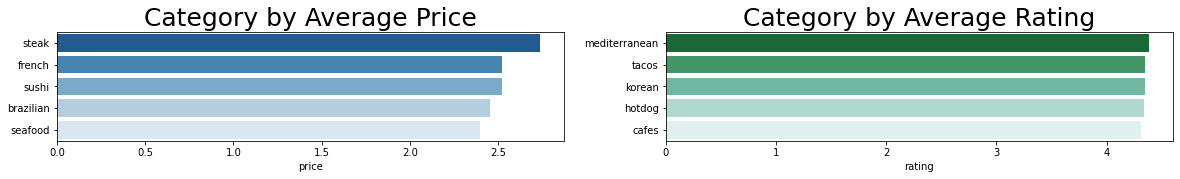

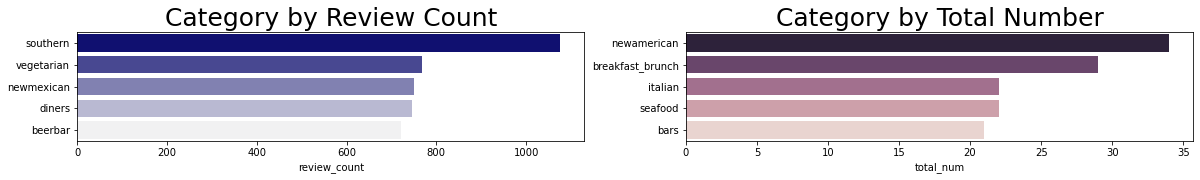

In [145]:
# let's map the top 5 of each category
m = 5

pr,ra,re,nu = pr.iloc[:m], ra.iloc[:m], re.iloc[:m], nu.iloc[:m]

#first fig
fig, axes = plt.subplots(1,2,figsize=(20,2))
sns.set_palette(sns.cubehelix_palette(8))

sns.barplot(data=pr,x='price',y='alias',orient='h',ax=axes[0], palette="Blues_r").set_title('Category by Average Price', fontsize=25)
axes[0].set_ylabel('')

sns.barplot(data=ra,x='rating',y='alias',orient='h',ax=axes[1], palette="BuGn_r").set_title('Category by Average Rating', fontsize=25)
axes[1].set_ylabel('')

# second fig
fig, axes = plt.subplots(1,2,figsize=(20,2))
sns.set_palette('ch:8')

sns.barplot(data=re,x='review_count',y='alias',orient='h',ax=axes[0], palette=sns.light_palette("navy", n_colors=m, reverse=True)).set_title('Category by Review Count', fontsize=25)
axes[0].set_ylabel('')

sns.barplot(data=nu,x='total_num',y='alias',orient='h',ax=axes[1], palette=sns.cubehelix_palette(m, reverse=True)).set_title('Category by Total Number', fontsize=25)
axes[1].set_ylabel('')

plt.show()

As expected, steaks, seafood, french foods and shuhi are expensive. Dallas has good mediterranean, tacos, korean; newamerican, breakfast_brunch and italian places are most common.

Most number of reviews are for southern food which is not surprising, but vegetarian places having second most reviews is surprising.

# Geographic Data

I was able to find a geoJSON file that has Dallas zip code boundary coordinates, which can be found [here](https://gist.github.com/boundaries-io/e2ba886a86cb942cec375d40e6fdd59a).

Unfortunately, the Dallas geojson file did not include an easily usable "key" for my data to attach to, such as a zip code, so I had to solve the problem of working with the only usable key, "name", the name of the region.

Using [this](https://www.geonames.org/postalcode-search.html?q=&country=US&adminCode1=TX) site, I was able to find the zip code respective to the areas that I wanted to use.

With that, came the work of trying to create a new column that corresponded to the "key" in the geojson file. I mapped the zip code to the exact name of the area in question.

Limitations: 
This geojsn file only includes Dallas. This means that the restaurants in nearby areas are not included in the maps.

In [146]:
import folium

with open('dallas_tx.geojson','r') as f:
    geojson = json.load(f)

# edit current dataframe to be readable by folium
df['zip_code'] = pd.concat([df.drop(['location'], axis=1), df['location'].apply(pd.Series)], axis=1)['zip_code']

### Average rating by area

In [147]:
dallas_map = folium.Map(
    location=[32.8586594, -96.76862],
    #tiles='Stamen Terrain',
    zoom_start=12
)
dallas_map.choropleth(geo_data=geojson, data=df, columns=['zip_code', 'rating'], key_on='feature.properties.zipCode',
                         fill_color='YlGn', fill_opacity=0.7,  line_opacity=0.2, nan_fill_color='black', nan_fill_opacity=0.2)
dallas_map

In this map: missing data is in grey.

### Restaurant density by area

In [148]:
dallas_map = folium.Map(
    location=[32.8586594, -96.76862],
    #tiles='Stamen Terrain',
    zoom_start=12
)
df_total_by_zip = df.groupby(['zip_code']).size().reset_index()
dallas_map.choropleth(geo_data=geojson, data=df_total_by_zip, columns=['zip_code', 0], key_on='feature.properties.zipCode',
                         fill_color='YlGn', fill_opacity=0.7, line_opacity=0.2, nan_fill_color='black', nan_fill_opacity=0.2)
dallas_map

### Price by area

In [149]:
print("Amount of missing price data: {}".format(df.price.isnull().sum()))
dallas_map = folium.Map(
    location=[32.8586594, -96.76862],
    #tiles='Stamen Terrain',
    zoom_start=12
)
dallas_map.choropleth(geo_data=geojson, data=df, columns=['zip_code', 'price'], key_on='feature.properties.zipCode', 
                         fill_color='YlGn', fill_opacity=0.7, line_opacity=0.2, nan_fill_color='black', nan_fill_opacity=0.2)
dallas_map

Amount of missing price data: 46


In this map: missing data is in grey.
    
Unfortunately, there is too much missing data for 'price'.

### Review count by area

In [150]:
dallas_map = folium.Map(
    location=[32.8586594, -96.76862],
    #tiles='Stamen Terrain',
    zoom_start=12
)
dallas_map.choropleth(geo_data=geojson, data=df, columns=['zip_code', 'review_count'], key_on='feature.properties.zipCode',
                         fill_color='YlGn', fill_opacity=0.7, line_opacity=0.2, nan_fill_color='black', nan_fill_opacity=0.2)
dallas_map

missing data is in grey.

Unfortunately there is a lot of missing data to make any conclusions based location